In [456]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.moist_physics import saturation_vapor_pressure, clausius_clapeyron_factor, sphum_sat, \
    sphum_from_dew, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory, get_approx_terms, get_sensitivity_factors, get_cape_approx, get_temp_adiabat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
from geopy.distance import geodesic
from scipy.ndimage import distance_transform_edt
import copy
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [5]:
def time_to_year(ds):
    ds = ds.assign_coords(year=ds['time'].dt.year)  # Add a 'year' coordinate
    ds = ds.swap_dims({'time': 'year'})             # Replace 'time' as dimension with 'year'
    ds = ds.drop_vars('time')                       # Optionally remove 'time' variable
    return ds

In [59]:
quant = 95
exp_path = ['./pre_industrial/output.nd2', './co2_2x/output.nd2']
exp_labels = ['Pre industrial', '$CO_2 \\times 2$']
n_exp = len(exp_path)
ds = []
for i in tqdm(range(n_exp)):
    ds.append(xr.load_dataset(exp_path[i]).isel(plev=0).sel(quant=quant).load())

  0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.load_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']]
invariant_data = invariant_data.reindex_like(ds[0]['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))
z2m = invariant_data.PHIS/g + 2

### Height
#### My Theory
In my theory, the geopotential height difference between free troposphere and surface is expressed in terms of surface temperature, $T_s$, free tropospheric temperature, $T_{500}$ and surface pressure $p_s$.

In my work up until now, I have been considering $\sigma$ levels so $p_s/p_{FT}$ has been the same everywhere. Or equally, I have been considering the same location over different percentiles, where again $p_s/p_{FT}$ does not change much.

But here, I am considering the same percentile at different spatial locations, thus the variation of $p_s$ is vital and cannot be neglected.

#### Zhang 2023
In the Zhang 2023 formulation, $z_{500}$ is expressed in terms of $T_{FT}$ only, and then $z_s$ is required as well to link $h_{FT}^*$ to $h_s$. Below we see that this approximation is less good compared to my equation, but it is still very reasonable.

This has the advantage of being in terms of $z_s$ rather than $p_s$; and that $z_s$ does not vary across the percentile distribution or with time, whereas $p_s$ does. So for considering spatial variation, it makes sense to do this formulation.

I think it will just end up with a $\Delta z_s$ term. This probably makes sense, as the larger $z_s$, the closer $p_s$ is to 500hPa, and so the closer $T_s$ will be to $T_{500}$. In the Tibetan Plateau, I think $p_s$ is actually lower than 500hPa.

In [215]:
# Mean 500-hPa values between 40N-65N over land during 1979-2021
z500_mean = 55.74162890625 * 1000 / g   # 5 km x 9.81 would be 55 so the zhang value of 55 must be in units of km multiplied by g. Convert to m by *1000/g
t500_mean = 258.82523

def get_z_theory(temp_surf, temp_ft, p_surf, p_ft=500*100, taylor=True):
    # Returns z500 - z2m
    R_mod = R * np.log(p_surf / p_ft)/2
    if taylor:
        return R_mod/g * (temp_surf + temp_ft)
    else:
        return (temp_surf - temp_ft) * 2 * R_mod / g / np.log(temp_surf / temp_ft)

def get_z_theory_zhang(temp_ft, z2m=z2m):
    # Returns z500 - z2m
    return z500_mean/t500_mean * temp_ft - z2m

z_diff_plot = {'simulated': ds[0].Z3 - z2m,
               'zhang': get_z_theory_zhang(ds[0].T),
               'theory': get_z_theory(ds[0].TREFHT, ds[0].T, ds[0].PS)}

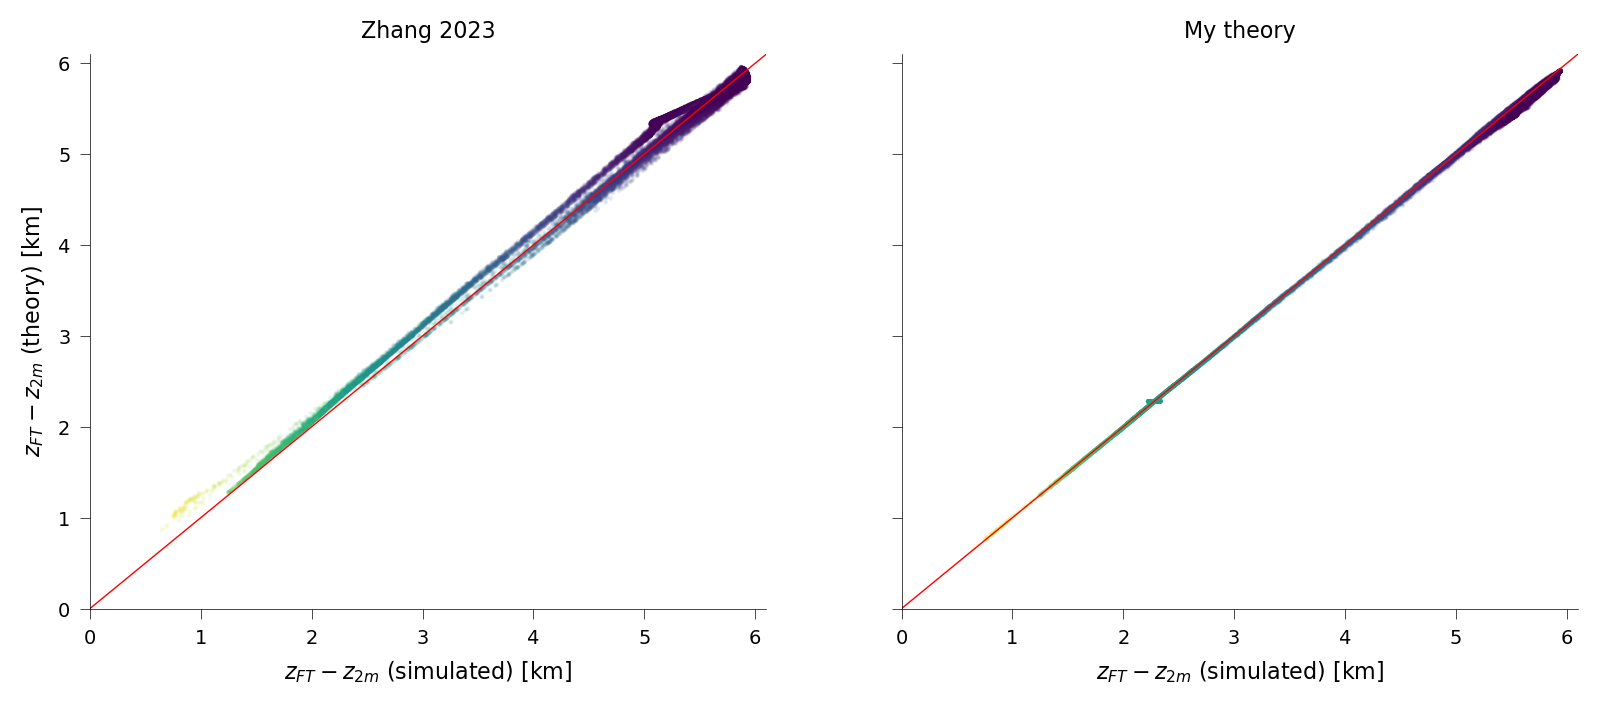

In [216]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
fig_resize(fig, 2*im_sz*width['one_col'])
ax[0].scatter(z_diff_plot['simulated']/1000, z_diff_plot['zhang']/1000,
              alpha=0.1, c=z2m/1000, cmap='viridis', s=0.5)
ax[1].scatter(z_diff_plot['simulated']/1000, z_diff_plot['theory']/1000,
              alpha=0.1, c=z2m/1000, cmap='viridis', s=0.5)
ax_lim = [0, 6.1]
for ax_use in ax:
    ax_use.set_xlabel('$z_{FT}-z_{2m}$ (simulated) [km]')
    ax_use.plot(ax_lim, ax_lim, color='r')
ax[0].set_ylim(ax_lim)
ax[0].set_xlim(ax_lim)
ax[0].set_ylabel('$z_{FT}-z_{2m}$ (theory) [km]')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
plt.show()

### Approx Surface Pressure
We would like to remove surface pressure from the theory, by assuming it just depends on surface geopotential, $z_{2m}$. This approximation is shown in orange below, and compared to a theory which includes the temperature dependence of $T_{2m}$. There is not much more benefit of including this temperature variation, so it makes sense to ignore it. This would mean that surface pressure remains constant with warming.

In [520]:
p0 = area_weighting(ds[0].PS.where(z2m<100)).mean()
T0 = area_weighting(ds[0].TREFHT.where(z2m<100)).mean()
ps_theory = p0 * np.exp(-g*z2m/R/ds[0].TREFHT)
ps_theory_just_z = p0 * np.exp(-g*z2m/R/T0)

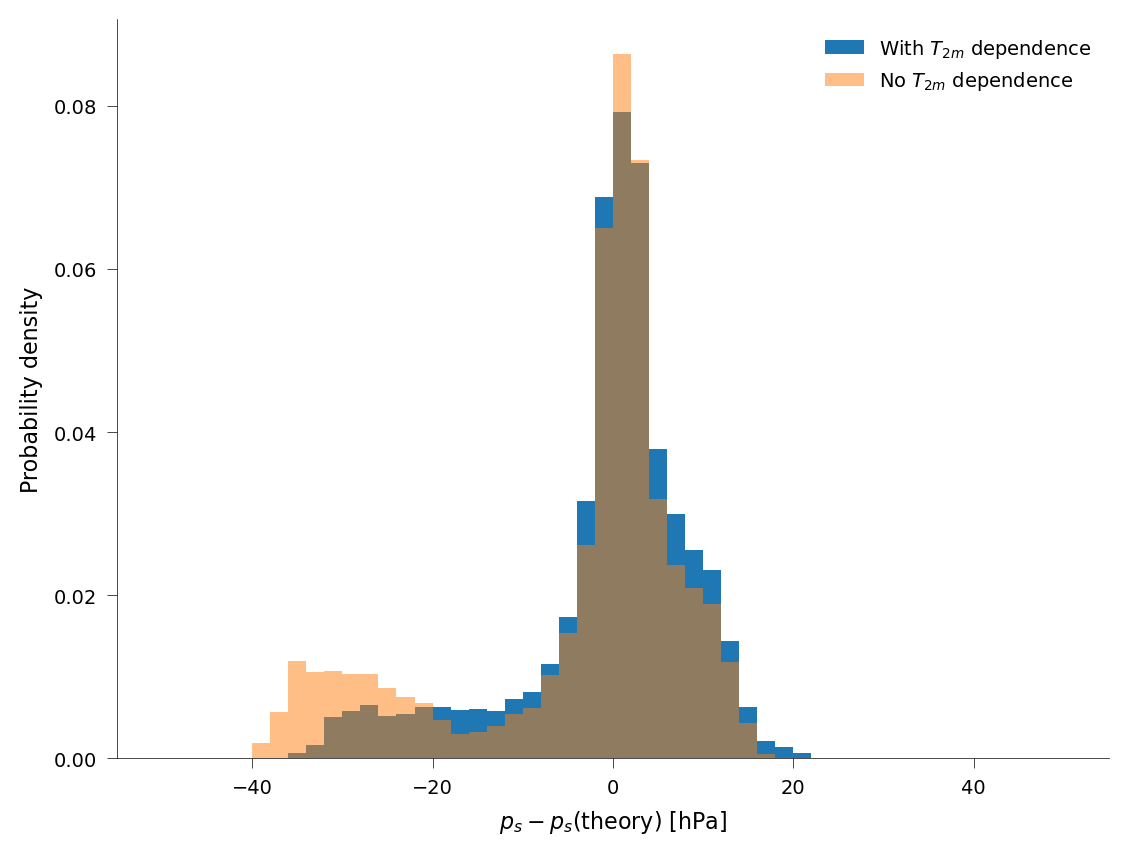

In [535]:
# plt.scatter(ds[0].PS, ps_theory, s=1)
# plt.scatter(ds[0].PS, ps_theory_just_z, s=1)
# plt.scatter(z2m.values.flatten(), ds[0].PS.values.flatten()-ps_theory.values.flatten(), c=land)
plt.hist((ds[0].PS.values.flatten()-ps_theory.values.flatten())/100, bins=np.linspace(-50, 50, 51), label='With $T_{2m}$ dependence', density=True)
plt.hist((ds[0].PS.values.flatten()-ps_theory_just_z.values.flatten())/100, bins=np.linspace(-50, 50, 51), alpha=0.5,
         label='No $T_{2m}$ dependence', density=True)
plt.legend()
plt.xlabel('$p_s - p_s$(theory) [hPa]')
plt.ylabel('Probability density')
plt.show()
# plt.plot([500*100, 1100*100], [500*100, 1100*100])

## Simulated change in 2m Temperature
Below we see arctic amplification to some degree over North America and Russia.

In [70]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.arange(40, 70, 25)):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

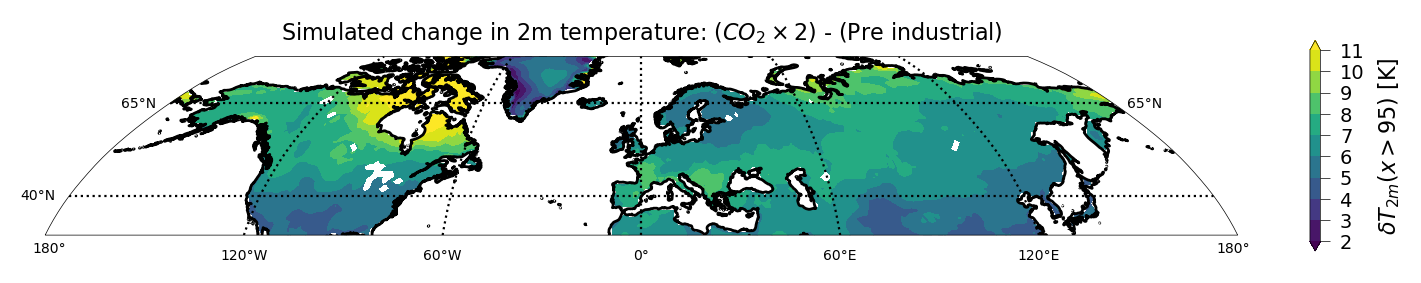

In [116]:
norm_by_ref = False
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax)

var = ds[1].TREFHT - ds[0].TREFHT
if norm_by_ref:
    var -= temp_surf_ref_change
    var *= mask_ref

im = plot_contour_projection(ax, var, norm_temp_levels if norm_by_ref else np.arange(2, 12, 1),
                             cmap='coolwarm' if norm_by_ref else 'viridis', mask=None if norm_by_ref else land)
fig.colorbar(shrink=0.8, ax=ax, label='$\delta T_{2m}(x>95)$ [K]', mappable=im)
ax.set_title(f'Simulated change in 2m temperature: ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()
# savefig(fig, format='png')

### Below LCL
Here I plot the height below the LCL, and the lapse rate in this region.

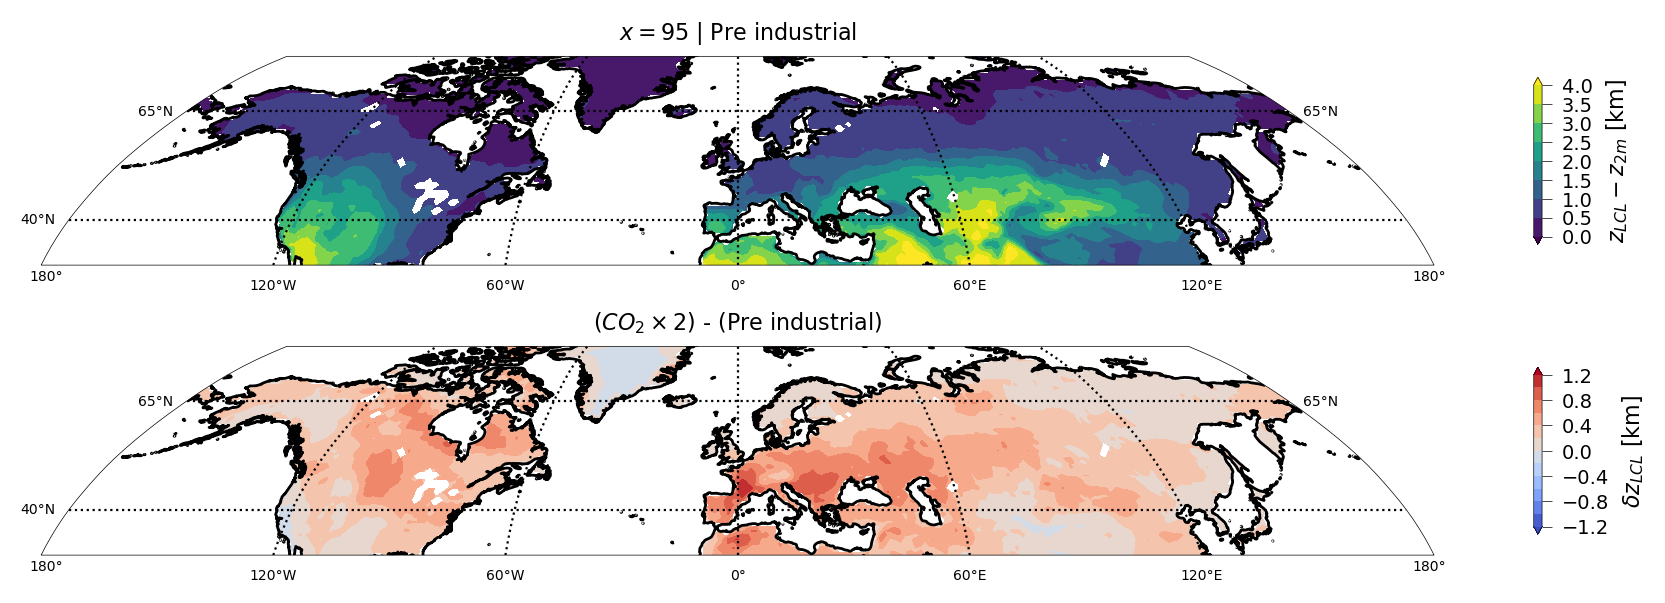

In [128]:
fig = plt.figure(constrained_layout=True,figsize=(10.,2.9))
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0])
initialize_ax_projection(ax[1])

im = plot_contour_projection(ax[0], (ds[0].Z3_at_lcl-z2m)/1000, levels=np.arange(0, 4.5, 0.5))
fig.colorbar(shrink=0.8, ax=ax[0], label='$z_{LCL}-z_{2m}$ [km]', mappable=im)
im = plot_contour_projection(ax[1], (ds[1].Z3_at_lcl-ds[0].Z3_at_lcl)/1000, levels=np.arange(-1.2, 1.3, 0.2), cmap='coolwarm')
fig.colorbar(shrink=0.8, ax=ax[1], label='$\delta z_{LCL}$ [km]', mappable=im)
ax[0].set_title(f'$x={quant}$ | {exp_labels[0]}')
ax[1].set_title(f'({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()
# savefig(fig, format='png')

In [171]:
for i in range(n_exp):
    ds[i]['lapse_below_lcl_reconstruct'] = (ds[i].T_at_lcl - ds[i].TREFHT) / (z2m - ds[i].Z3_at_lcl) * 1000
    ds[i]['lapse_above_lcl_reconstruct'] = (ds[i].T - ds[i].T_at_lcl) / (ds[i].Z3_at_lcl - ds[i].Z3) * 1000

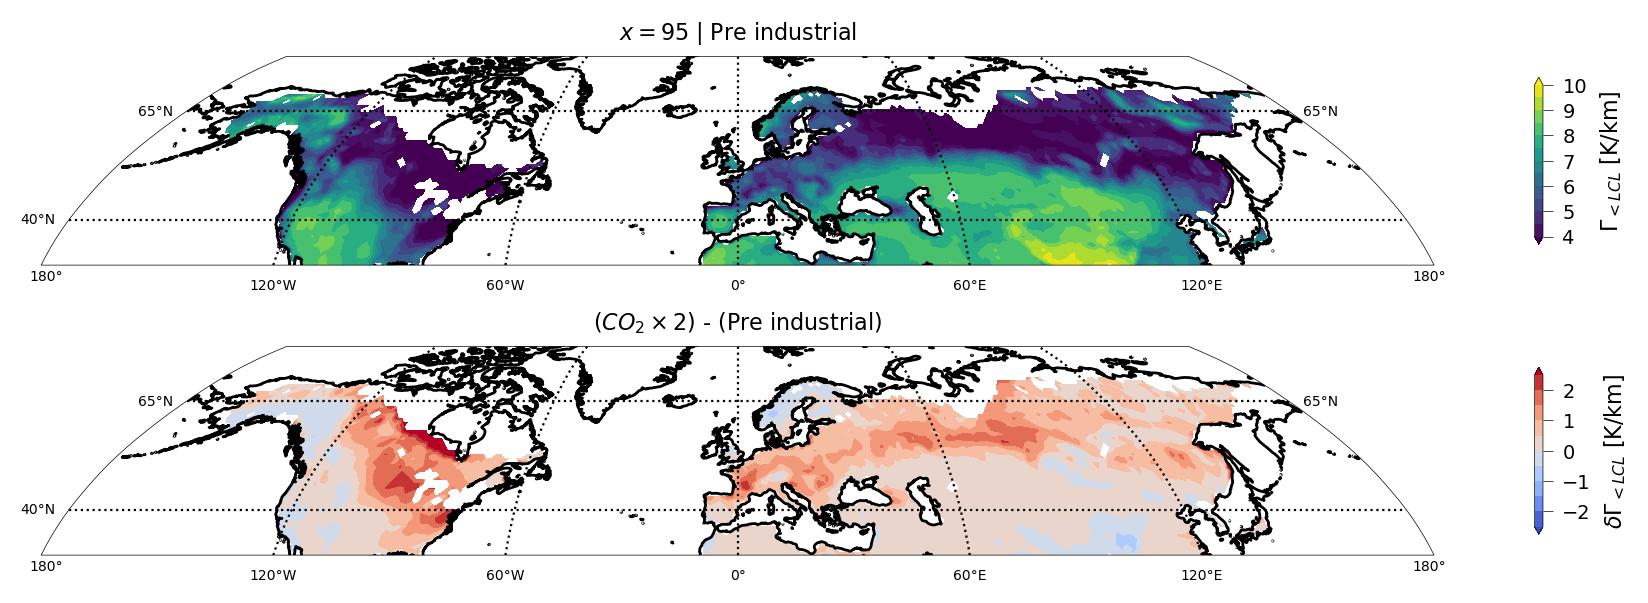

In [174]:
show_reconstruct = False
fig = plt.figure(constrained_layout=True,figsize=(10.,2.9))
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0])
initialize_ax_projection(ax[1])

var = 'lapse_below_lcl_reconstruct' if show_reconstruct else 'lapse_below_lcl'

mask = land * (ds[0].Z3_at_lcl-z2m>500)    # only show regions where at least 500m between surface and LCL
mask = mask.where(mask>0)
im = plot_contour_projection(ax[0], ds[0][var], levels=np.arange(4, 10.5, 0.5), mask=mask)
fig.colorbar(shrink=0.8, ax=ax[0], label='$\Gamma_{<LCL}$ [K/km]', mappable=im)
im = plot_contour_projection(ax[1], ds[1][var]-ds[0][var], levels=np.arange(-2.5, 3, 0.5), cmap='coolwarm', mask=mask)
fig.colorbar(shrink=0.8, ax=ax[1], label='$\delta \Gamma_{<LCL}$ [K/km]', mappable=im)
ax[0].set_title(f'$x={quant}$ | {exp_labels[0]}')
ax[1].set_title(f'({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

#### Comparison of calc offline to online
Below I show that the computation of the lapse rate is significantly larger if done using the individual averaged quantities compared to computing the lapse rate for each day and taking the average of these.

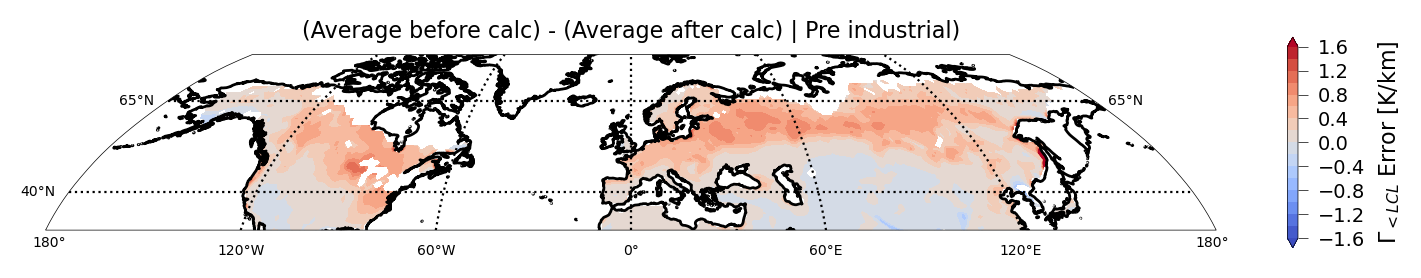

In [175]:
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax)
im = plot_contour_projection(ax, lapse_below_lcl_reconstruct[0] - ds[0].lapse_below_lcl, levels=np.arange(-1.6, 1.8, 0.2), cmap='coolwarm', mask=mask)
fig.colorbar(shrink=0.8, ax=ax, label='$\Gamma_{<LCL}$ Error [K/km]', mappable=im)
ax.set_title(f'(Average before calc) - (Average after calc) | {exp_labels[0]})')
plt.show()

### Above LCL
Here, I plot the distance in geopotential between the LCL and 500hPa, as well as the lapse rate in this region.

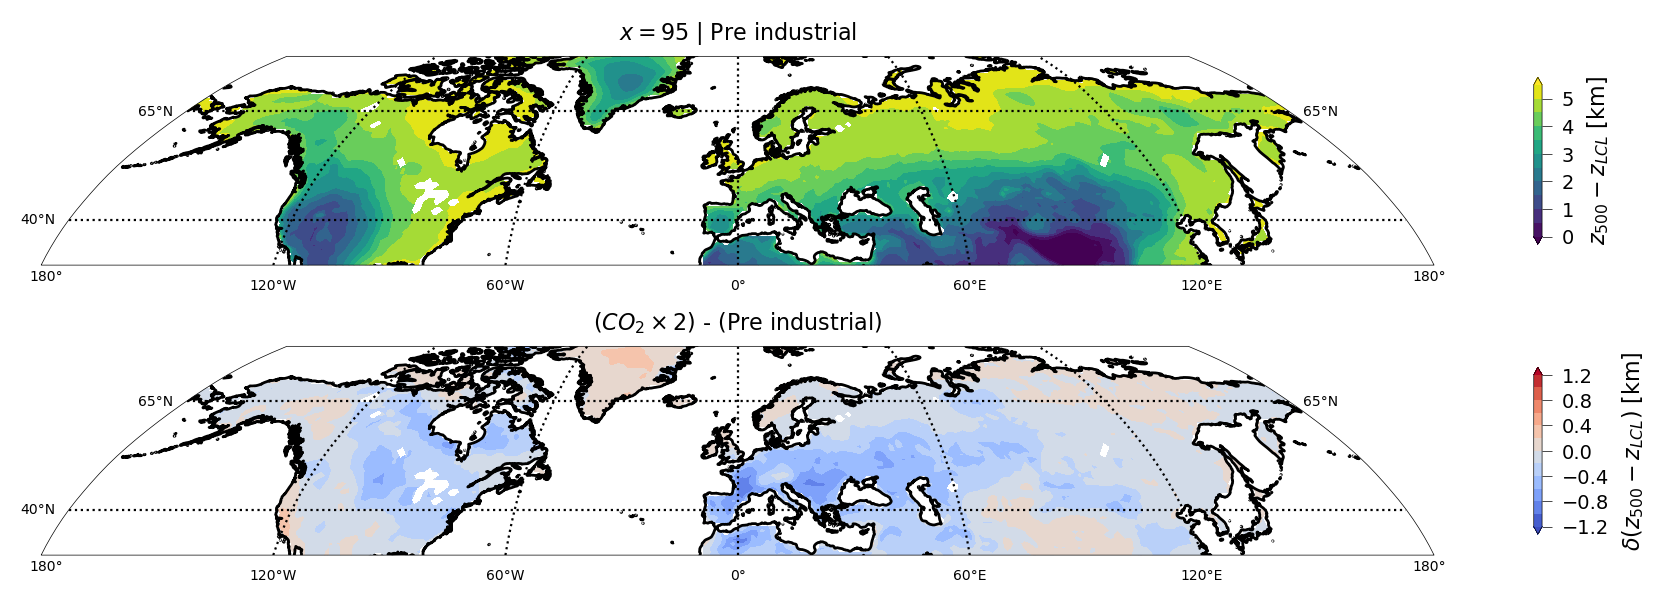

In [129]:
fig = plt.figure(constrained_layout=True,figsize=(10.,2.9))
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0])
initialize_ax_projection(ax[1])

im = plot_contour_projection(ax[0], (ds[0].Z3-ds[0].Z3_at_lcl)/1000, levels=np.arange(0, 6, 0.5))
fig.colorbar(shrink=0.8, ax=ax[0], label='$z_{500}-z_{LCL}$ [km]', mappable=im)
im = plot_contour_projection(ax[1], ((ds[1].Z3-ds[1].Z3_at_lcl) - (ds[0].Z3-ds[0].Z3_at_lcl))/1000, levels=np.arange(-1.2, 1.3, 0.2), cmap='coolwarm')
fig.colorbar(shrink=0.8, ax=ax[1], label='$\delta (z_{500}-z_{LCL})$ [km]', mappable=im)
ax[0].set_title(f'$x={quant}$ | {exp_labels[0]}')
ax[1].set_title(f'({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

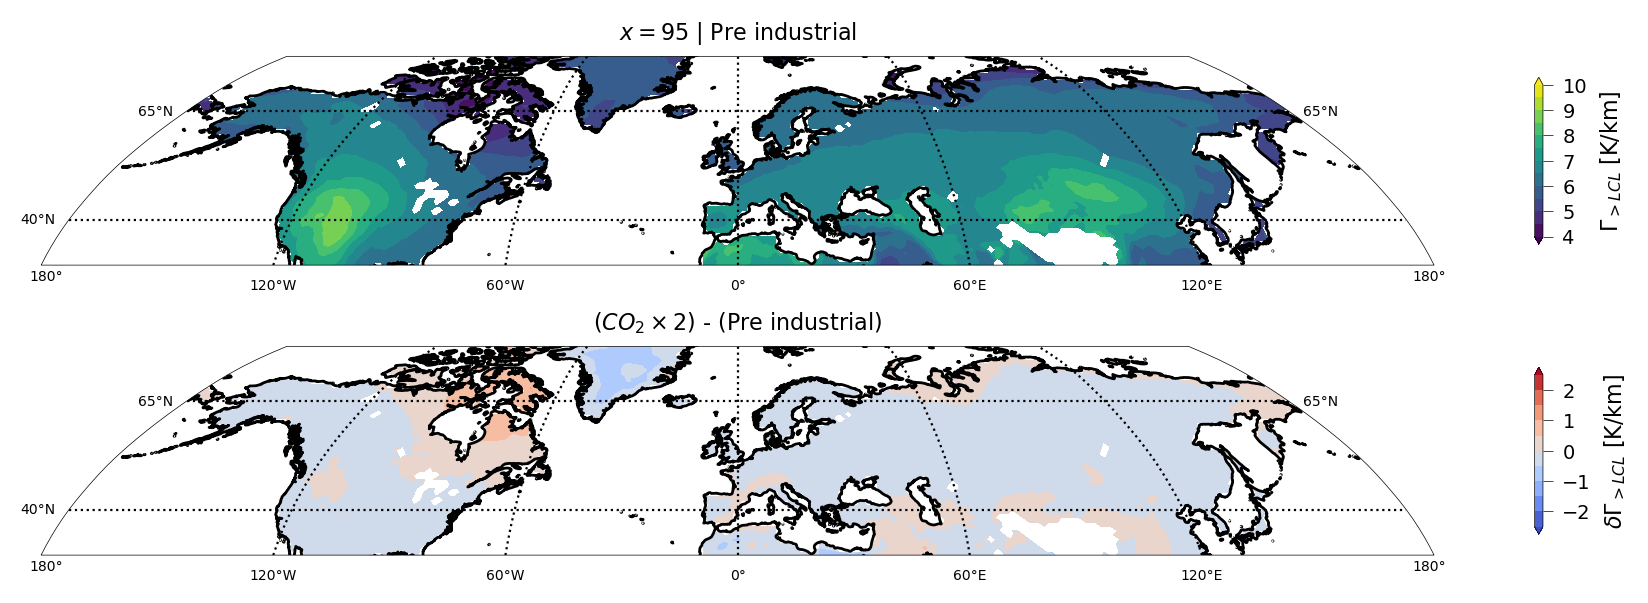

In [178]:
show_reconstruct = False
fig = plt.figure(constrained_layout=True,figsize=(10.,2.9))
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0])
initialize_ax_projection(ax[1])

var = 'lapse_above_lcl_reconstruct' if show_reconstruct else 'lapse_above_lcl'

mask = land * (ds[0].Z3-ds[0].Z3_at_lcl>500)    # only show regions where at least 500m between LCL and 500hPa
mask = mask.where(mask>0)
im = plot_contour_projection(ax[0], ds[0][var], levels=np.arange(4, 10.5, 0.5), mask=mask)
fig.colorbar(shrink=0.8, ax=ax[0], label='$\Gamma_{>LCL}$ [K/km]', mappable=im)
im = plot_contour_projection(ax[1], ds[1][var]-ds[0][var], levels=np.arange(-2.5, 3, 0.5), cmap='coolwarm', mask=mask)
fig.colorbar(shrink=0.8, ax=ax[1], label='$\delta \Gamma_{>LCL}$ [K/km]', mappable=im)
ax[0].set_title(f'$x={quant}$ | {exp_labels[0]}')
ax[1].set_title(f'({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

## Equation for $T_{2m}$
Below, I compute the equation for $T_{2m}$ from the lapse rates and LCL levels.

The first method is just $T_{2m} = T_{500} + \Gamma_{<LCL} (z_{LCL} - z_{2m}) + \Gamma_{>LCL} (z_{500}-z_{LCL})$. And then use the Zhang formula to relate $T_{500} = \overline{T_{500}}/ \overline{z_{500}} z_{500}$. So $T_{2m}$ only depends on $T_{500}, \Gamma_{<LCL}, z_{LCL}, \Gamma_{>LCL}$.

The second method works exclusively in pressure coordinates, arising from just hydrostatic eqb, ideal gas law and assuming constant lapse rate both between 2m and LCL, and between LCL and 500hPa. This gives:

$\ln(\frac{p_s}{p_{LCL}}) = \frac{g}{R\Gamma_1}\ln(\frac{T_{2m}}{T_{LCL}})$ and $\ln(\frac{p_{LCL}}{p_{500}}) = \frac{g}{R\Gamma_2}\ln(\frac{T_{LCL}}{T_{500}})$

Which can be combined to give:

$$T_{2m} = T_{500}\left(p_s^{\Gamma_1} p_{500}^{-\Gamma_2} p_{LCL}^{\Gamma_2 - \Gamma_1}\right)^{R/g} =
T_{500}\left((p_s/p_{LCL})^{\Gamma_1-\Gamma_2}(p_s/p_{500})^{\Gamma_2}\right)$$

I think this method makes more sense, as never involves $z_{500}$, and can then simplify by assuming $p_s$ just depends on surface geopotential height. And can also write in terms of $p_{LCL}/p_s$ which is what formula for LCL gives. Where $\Gamma_1 = \Gamma_{<LCL}$ and $\Gamma_2 = \Gamma_{>LCL}$.

In [608]:
def get_TREFHT_reconstruct(T500, z_lcl, lapse_below_lcl, lapse_above_lcl, z2m=z2m, z500=None):
    if z500 is None:
        z500_T500 = z500_mean / t500_mean
    else:
        z500_T500 = z500 / T500
    # return T500 + lapse_below_lcl/1000 * (z_lcl - z2m) + lapse_above_lcl/1000 * (z500_T500*T500 - z_lcl)
    return T500 * (1 + z500_T500 * lapse_above_lcl/1000) + z_lcl * (lapse_below_lcl - lapse_above_lcl)/1000 - lapse_below_lcl/1000 * z2m
TREFHT_recon = [get_TREFHT_reconstruct(ds[i].T, ds[i].Z3_at_lcl, ds[i].lapse_below_lcl_reconstruct, ds[i].lapse_above_lcl_reconstruct)
                for i in range(n_exp)]
print(float((ds[0].TREFHT-TREFHT_recon[0]).median()))

-0.026699821908749755


In [544]:
def get_TREFHT_reconstruct2(T500, p_lcl, lapse_below_lcl, lapse_above_lcl, p_ft=500*100, ps=ps_theory_just_z):
    # This equation should be exact if use actual surface pressure, ps, instead of theoretical dependence on just z_2m
    return T500 * (ps**(lapse_below_lcl/1000) * p_ft**(-lapse_above_lcl/1000) * p_lcl**(lapse_above_lcl/1000-lapse_below_lcl/1000))**(R/g)

In [587]:
# Equation for lapse rates from temperature and pressure levels from hydrostatic eqb, ideal gas law, assume constant lapse rate
lapse_below_lcl_reconstruct2 = [g/R * np.log(ds[i].TREFHT/ds[i].T_at_lcl) / np.log(ds[i].PS/ds[i].p_at_lcl) * 1000 for i in range(n_exp)]
lapse_above_lcl_reconstruct2 = [g/R * np.log(ds[i].T_at_lcl/ds[i].T) / np.log(ds[i].p_at_lcl/ds[i].plev) * 1000 for i in range(n_exp)]

In [609]:
TREFHT_recon2 = [get_TREFHT_reconstruct2(ds[i].T, ds[i].p_at_lcl, lapse_below_lcl_reconstruct2[i],
                                         lapse_above_lcl_reconstruct2[i]) for i in range(n_exp)]
print(float((ds[0].TREFHT-TREFHT_recon2[0]).median()))

0.021027867324647787


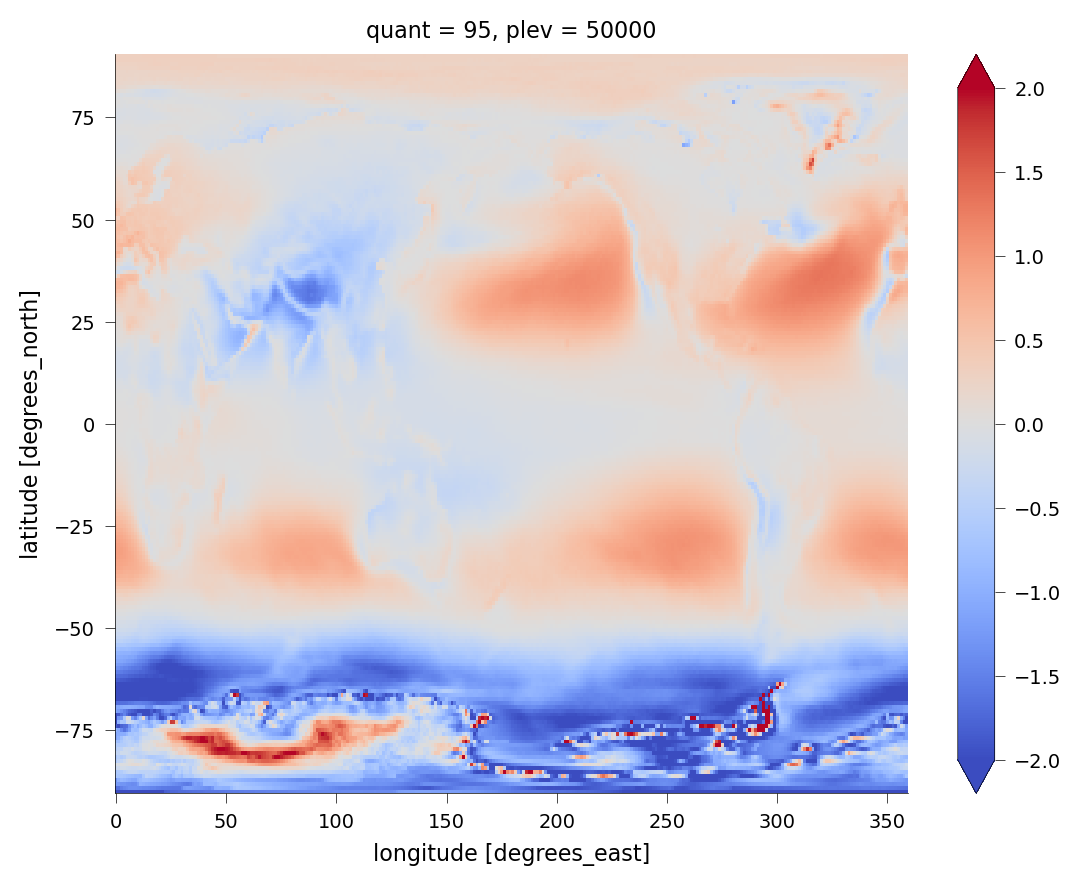

In [613]:
(ds[0].TREFHT - TREFHT_recon2[0]).plot(vmin=-2, vmax=2, cmap='coolwarm')

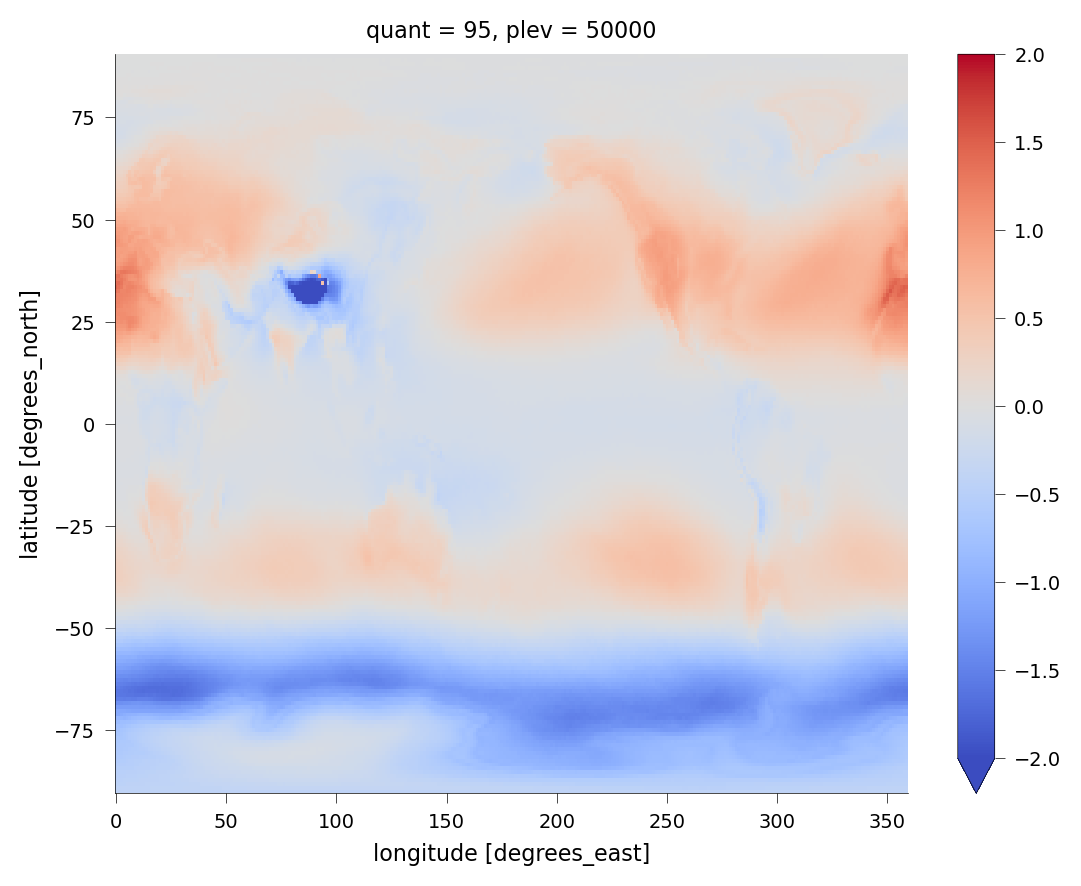

In [601]:
(ds[0].TREFHT - TREFHT_recon[0]).plot(vmin=-2, vmax=2, cmap='coolwarm')

In [539]:
(ds[0].T_at_lcl - ds[0].TREFHT).where(ds[0].Z3_lcl<z2m).mean()

<xarray.DataArray ()> Size: 4B
array(2.8857055, dtype=float32)
Coordinates:
    quant    int64 8B 95
    plev     int64 8B 50000

In [439]:
TREFHT_change_breakdown_change = {'T500': ds[1].T-ds[0].T,
              'lapse_below_lcl': ds[1].lapse_below_lcl_reconstruct - ds[0].lapse_below_lcl_reconstruct,
              'z_lcl': (ds[1].Z3_at_lcl - ds[0].Z3_at_lcl)/1000,
              'lapse_above_lcl': ds[1].lapse_above_lcl_reconstruct - ds[0].lapse_above_lcl_reconstruct}
TREFHT_change_breakdown_sensitivity = {'T500': 1 + z500_mean / t500_mean * ds[0].lapse_above_lcl_reconstruct/1000,
                   'lapse_below_lcl': (ds[0].Z3_at_lcl - z2m)/1000,
                   'z_lcl': ds[0].lapse_below_lcl_reconstruct - ds[0].lapse_above_lcl_reconstruct,
                   'lapse_above_lcl': (z500_mean / t500_mean * ds[0].T - ds[0].Z3_at_lcl)/1000}
TREFHT_change_breakdown_cont = {key: TREFHT_change_breakdown_change[key] * TREFHT_change_breakdown_sensitivity[key]
                              for key in TREFHT_change_breakdown_change}
TREFHT_change_theory = sum(TREFHT_change_breakdown_cont.values())

In [440]:
def get_ref_var(var, lat_min=30, lat_max=80, mask=land):
    return var.sel(lat=slice(lat_min, lat_max)).where(mask).mean()

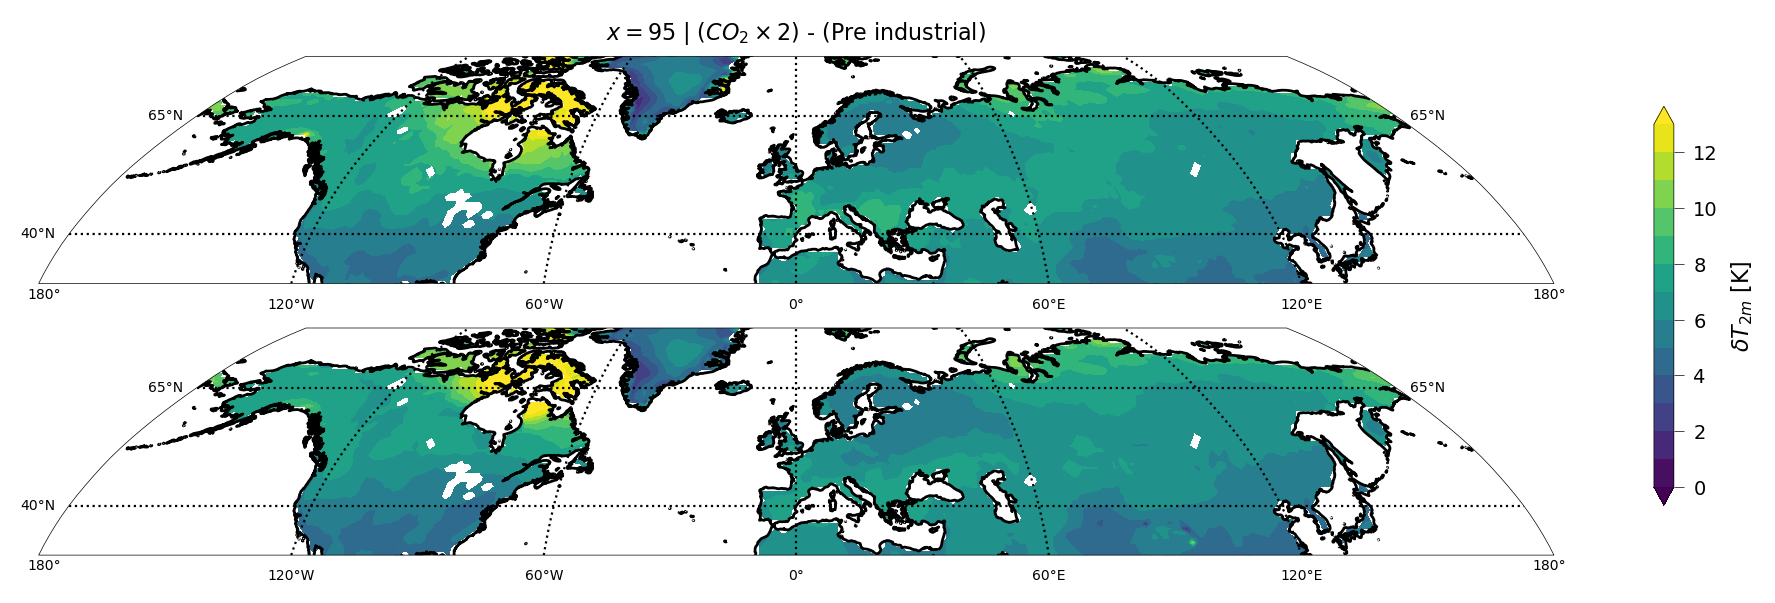

In [441]:
norm = False
norm_levels = np.arange(-5, 6)
fig = plt.figure(constrained_layout=True,figsize=(10.,2.9))
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0])
initialize_ax_projection(ax[1])

var = 'lapse_above_lcl_reconstruct' if show_reconstruct else 'lapse_above_lcl'

# mask = land * (ds[0].Z3-ds[0].Z3_at_lcl>500)    # only show regions where at least 500m between LCL and 500hPa
# mask = mask.where(mask>0)
im = plot_contour_projection(ax[0], ds[1].TREFHT-ds[0].TREFHT - (get_ref_var(ds[1].TREFHT-ds[0].TREFHT) if norm else 0),
                             levels=norm_levels if norm else np.arange(0, 14),
                             cmap='coolwarm' if norm else 'viridis')
im = plot_contour_projection(ax[1], TREFHT_change_theory - (get_ref_var(ds[1].TREFHT-ds[0].TREFHT) if norm else 0),
                                 levels=norm_levels if norm else np.arange(0, 14),
                             cmap='coolwarm' if norm else 'viridis')
fig.colorbar(shrink=0.8, ax=ax, label='$\delta T_{2m}$ [K]', mappable=im)
ax[0].set_title(f'$x={quant}$ | ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

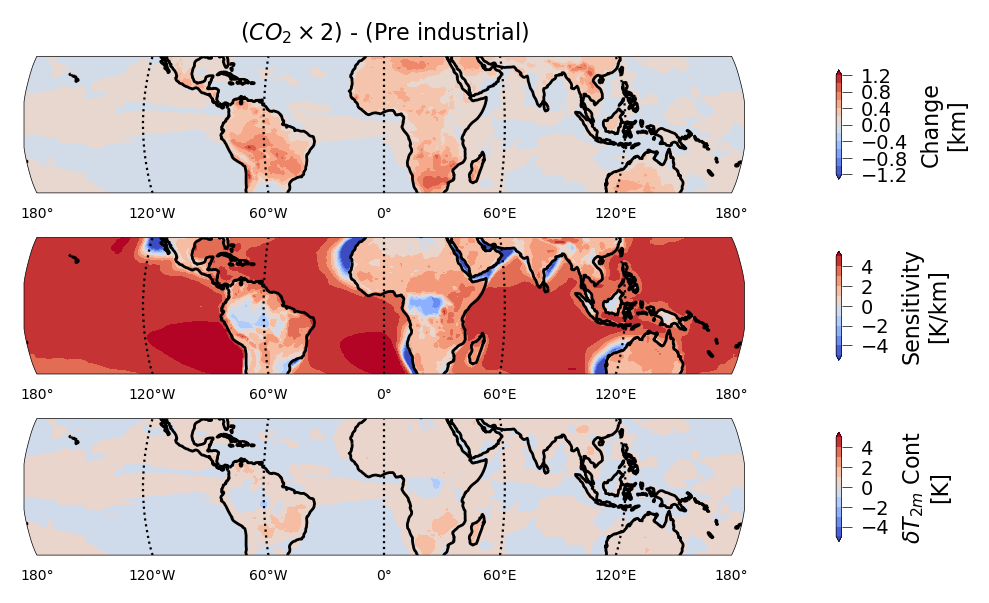

In [451]:
key = 'z_lcl'
norm = False
fig = plt.figure(constrained_layout=True,figsize=(10.,2.9))
ax = fig.subplots(3,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=-30, lat_max=30)
initialize_ax_projection(ax[1], lat_min=-30, lat_max=30)
initialize_ax_projection(ax[2], lat_min=-30, lat_max=30)
im = plot_contour_projection(ax[0], TREFHT_change_breakdown_change[key], levels=np.arange(-1.2, 1.3, 0.2), cmap='coolwarm', mask=None)
fig.colorbar(shrink=0.8, ax=ax[0], label=f'Change\n[{"km" if "z" in key else "K/km"}]', mappable=im)
im = plot_contour_projection(ax[1], TREFHT_change_breakdown_sensitivity[key], levels=np.arange(-5, 6, 1), cmap='coolwarm', mask=None)
fig.colorbar(shrink=0.8, ax=ax[1], label=f'Sensitivity\n[{"K/km" if "z" in key else "km"}]', mappable=im)
im = plot_contour_projection(ax[2], TREFHT_change_breakdown_cont[key],
                             cmap='coolwarm' if (norm or key != 'T500') else 'viridis',
                             levels=norm_levels if (norm or key != 'T500') else np.arange(0, 14), mask=None)
fig.colorbar(shrink=0.8, ax=ax[2], label='$\delta T_{2m}$ Cont\n[K]', mappable=im)
ax[0].set_title(f'({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

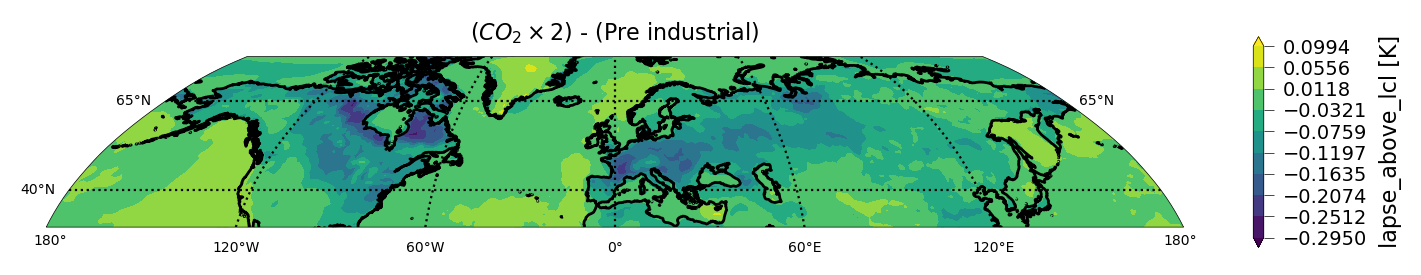

In [418]:
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax)
im = plot_contour_projection(ax, ds[1].rh_refht - ds[0].rh_refht, mask=None)
fig.colorbar(shrink=0.8, ax=ax, label=f'{key} [K]', mappable=im)
ax.set_title(f'({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()